## Measuring Box Sizes and Rotations

This notebook is designed to measure approximate box sizes and rotations for each survey footprint.

In [ ]:
%load_ext autoreload
%autoreload 2

import os
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import h5py
import healpy as hp

from astropy.cosmology import Planck18 as cosmo
from cmass.survey.tools import sky_to_xyz

wdir = '/ocean/projects/phy240015p/mho1/cmass-ili'


### Functions

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation as R


def align_point_cloud(xyz: np.ndarray) -> tuple[np.ndarray, R]:
    """
    Aligns a point cloud and returns the final positions and total rotation.

    The alignment is a two-step process:
    1. The mean of the cloud is aligned with the +x-axis.
    2. The cloud is rotated around the x-axis so its largest variance
       lies along the y-axis.
    """
    # 1. First rotation: Align the mean vector (line-of-sight) with the x-axis.
    los = np.mean(xyz, axis=0)

    # Handle the edge case where the mean is at the origin
    if np.linalg.norm(los) < 1e-9:
        rotation1 = R.identity()
    else:
        target_vector = np.array([1, 0, 0]) * np.linalg.norm(los)
        rotation1, _ = R.align_vectors([target_vector], [los])

    pos_step1 = rotation1.apply(xyz)

    # 2. Second rotation: Align the largest variance with the y-axis.
    # This resolves the azimuthal ambiguity from the first rotation.
    pos_centered = pos_step1 - np.mean(pos_step1, axis=0)

    # PCA on the Y-Z plane requires at least 2 points to compute covariance
    if xyz.shape[0] < 2:
        rotation2 = R.identity()
    else:
        covariance_matrix = np.cov(pos_centered[:, 1:], rowvar=False)
        eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)
        pc1 = eigenvectors[:, -1]  # Principal component is the last eigenvector

        # Calculate the angle to rotate pc1 onto the y-axis ([1, 0])
        angle_rad = -np.arctan2(pc1[1], pc1[0])  # Angle is arctan(z/y)
        rotation2 = R.from_euler('x', angle_rad)

    # 3. Combine rotations and calculate the final position
    # The total rotation is applying rotation1, then rotation2.
    total_rotation = rotation2 * rotation1
    return total_rotation


def plot_box(ax, boxsize, boxcenter):
    # Define the box corners
    half_size = boxsize / 2
    corners = np.array([
        [-half_size, -half_size, -half_size],
        [-half_size, -half_size,  half_size],
        [-half_size,  half_size, -half_size],
        [-half_size,  half_size,  half_size],
        [half_size, -half_size, -half_size],
        [half_size, -half_size,  half_size],
        [half_size,  half_size, -half_size],
        [half_size,  half_size,  half_size]
    ]) + boxcenter

    # Define the edges of the box
    edges = [
        [0, 1], [0, 2], [0, 4], [1, 3], [1, 5], [2, 3],
        [2, 6], [3, 7], [4, 5], [4, 6], [5, 7], [6, 7]
    ]

    # Plot the edges of the box
    for edge in edges:
        ax.plot3D(*corners[edge].T, c='r', lw=0.5,
                  label='Bounding Box' if edge == edges[0] else "")


def calculate_sky_fraction_healpix(ra, dec, nside=128):
    """
    Calculates the sky fraction using the HEALPix method.
    """
    # Convert RA and Dec from degrees to radians
    theta = np.deg2rad(90.0 - dec)
    phi = np.deg2rad(ra)

    # Find the unique HEALPix pixels that contain galaxies
    pixel_indices = hp.ang2pix(nside, theta, phi)
    unique_pixels = np.unique(pixel_indices)

    # The sky fraction is the ratio of occupied pixels to the total number of pixels
    sky_fraction = len(unique_pixels) / hp.nside2npix(nside)

    return sky_fraction

### All data

In [18]:

# # SIMBIG
# nbody = 'real_data'
# sim = 'cmass_simbig'  # TODO: this could probably be replaced with real data
# L, N = 2000, 256
# lhid = 0
# simdir = join(wdir, nbody, sim, f'L{L}-N{N}', str(lhid))
# tracer = 'simbig_lightcone'
# file = 'hod00000_aug00000.h5'

# # SGC
# nbody = 'real_data'
# sim = 'cmass_sgc'
# L, N = 2000, 256
# lhid = 0
# simdir = join(wdir, nbody, sim, f'L{L}-N{N}', str(lhid))
# tracer = 'sgc_lightcone'
# file = 'hod00000_aug00000.h5'

# # MTNG
# nbody = 'mtng'
# sim = 'nbody'
# L, N = 3000, 384
# lhid = 0
# simdir = join(wdir, nbody, sim, f'L{L}-N{N}', str(lhid))
# tracer = 'mtng_lightcone'
# file = 'hod00000_aug00000.h5'

# NGC
nbody = 'real_data'
sim = 'cmass_ngc'
L, N = 3000, 384
lhid = 0
simdir = join(wdir, nbody, sim, f'L{L}-N{N}', str(lhid))
tracer = 'ngc_lightcone'
file = 'hod00000_aug00000.h5'

In [19]:
# Load data and convert to comoving
with h5py.File(join(simdir, tracer, file), 'r') as f:
    rdz = np.stack([f['ra'][:], f['dec'][:], f['z'][:]], axis=-1)

xyz = sky_to_xyz(rdz, cosmo=cosmo)

In [20]:
print(tracer, '\n')

fsky = calculate_sky_fraction_healpix(rdz[:, 0], rdz[:, 1], nside=128)
print(f'Sky fraction:\n\t{fsky:.4f}')

# Measure optimal survey geometries
rotation = align_point_cloud(xyz)
rotmatrix = rotation.as_matrix()
print('Rotation:\n\t', repr(rotmatrix))

xyzR = xyz @ rotmatrix.T
boxpad = 1.2
Lvoxel = 1000/128

# Define box size and center (multiple of Lvoxel)
boxsize = np.max(np.max(xyzR, axis=0) - np.min(xyzR, axis=0))
boxsize = np.ceil(boxpad * boxsize / Lvoxel) * Lvoxel
boxcenter = 0.5 * (np.max(xyzR, axis=0) + np.min(xyzR, axis=0))
print(f'Box size:\n\t {boxsize:.1f}')
print('Box center:\n\t', repr(boxcenter))

outside_box = np.sum(np.any(np.abs(xyzR - boxcenter) > boxsize / 2, axis=1))
print(f'Total number of points outside the box: {outside_box}')

ngc_lightcone 

Sky fraction:
	0.1822
Rotation:
	 array([[-0.82592816, -0.0703174 ,  0.55937298],
       [ 0.09292135, -0.99560058,  0.0120462 ],
       [ 0.55606501,  0.06192699,  0.82882854]])
Box size:
	 3750.0
Box center:
	 array([1063.28224848,  -12.57940443,  -11.66296504])
Total number of points outside the box: 0


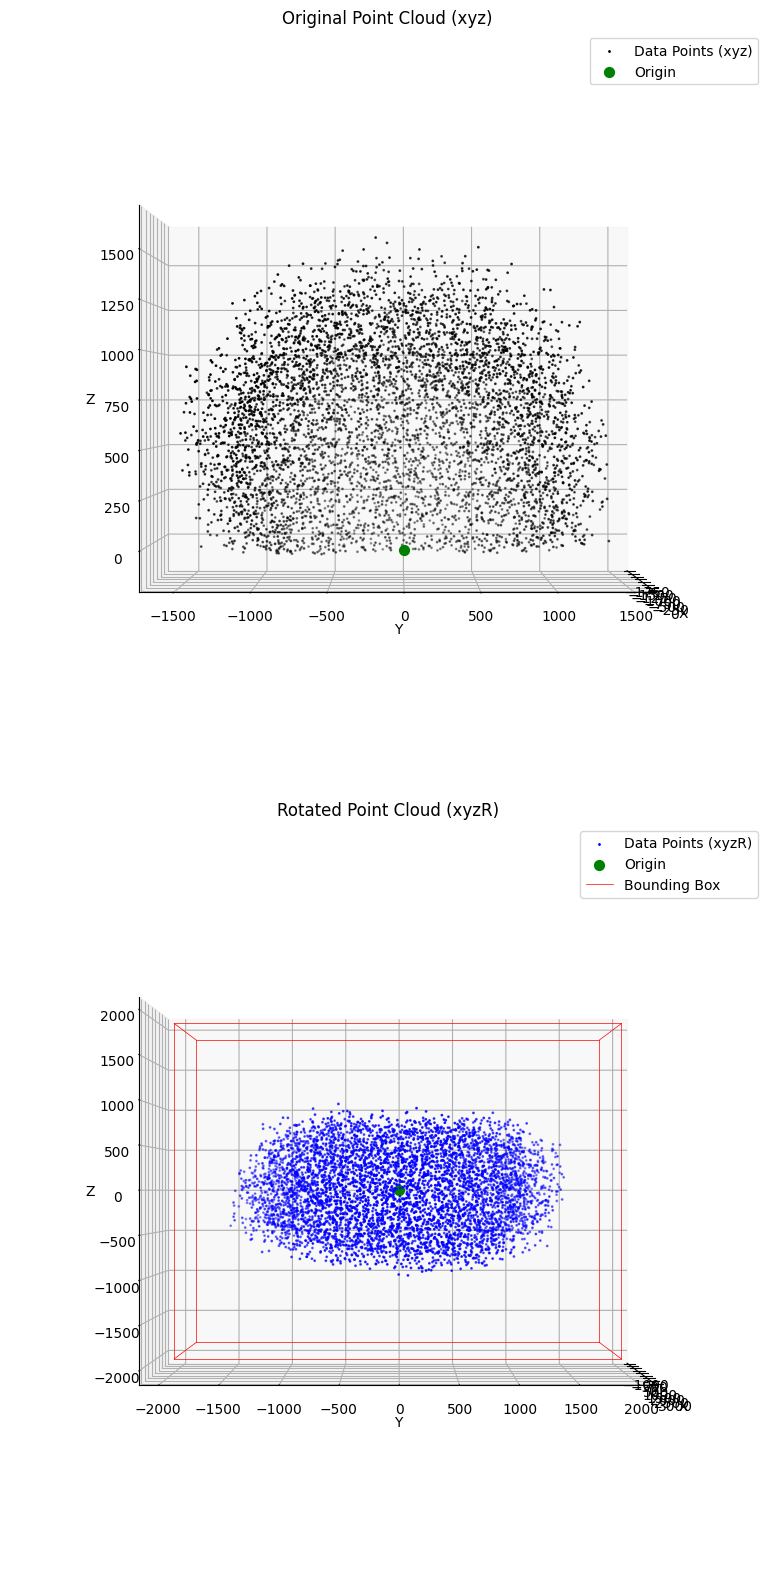

In [21]:
# Plot
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16, 16))

ss = 100
elev, azim = 0, 0
# elev, azim = 0, 90

# First subplot for xyz
ax1 = fig.add_subplot(211, projection='3d')
ax1.scatter(xyz[::ss, 0], xyz[::ss, 1], xyz[::ss, 2],
            c='k', s=1, label='Data Points (xyz)')
ax1.scatter(*np.zeros(3), c='g', s=50, label='Origin')
ax1.set_title('Original Point Cloud (xyz)')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.view_init(elev=elev, azim=azim)

# Second subplot for xyzR
ax2 = fig.add_subplot(212, projection='3d')
ax2.scatter(xyzR[::ss, 0], xyzR[::ss, 1], xyzR[::ss, 2],
            c='b', s=1, label='Data Points (xyzR)')
ax2.scatter(*np.zeros(3), c='g', s=50, label='Origin')


plot_box(ax2, boxsize, boxcenter)
ax2.set_title('Rotated Point Cloud (xyzR)')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.legend()
ax2.view_init(elev=elev, azim=azim)

plt.tight_layout()